In [154]:
import sklearn
import numpy as np
from keras.datasets import cifar10, mnist, imdb
from random import randrange
import time

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

In [6]:
from imageio import imread

# Работа с изображениями

* Как представлены изображения на компьютере?
* Как с ними работать?

In [7]:
image = imread('cat.jpg')

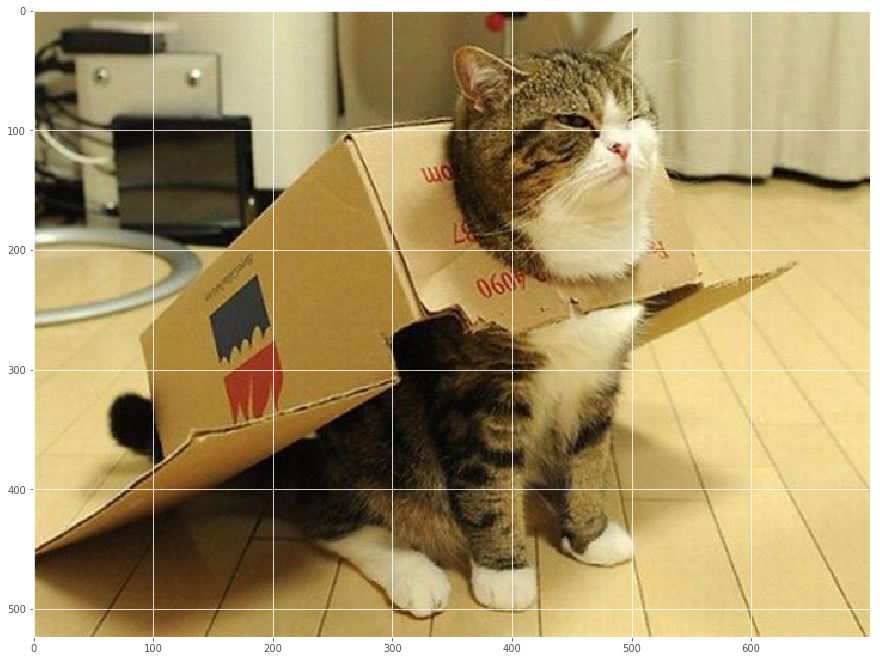

In [17]:
plt.imshow(image)

Каждое изображение представлено тремя матрицами, по одной на каждый цветовой канал (RGB):

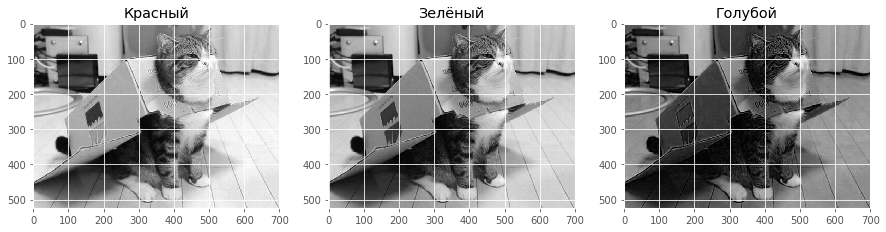

In [18]:
fig = plt.figure()
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(image[:,:,0], cmap='gray')
a.set_title('Красный')
a=fig.add_subplot(1,3,2)
imgplot = plt.imshow(image[:,:,1], cmap='gray')
a.set_title('Зелёный')
a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(image[:,:,2], cmap='gray')
a.set_title('Голубой')
plt.show()

Элементы матриц принимают значения от $0$ до $255$ и обозначают интенсивность одного из трёх цветов.

Для удобства все три матрицы хранятся вместе в одном трёхмерном массиве, где третий индекс отвечает за номер канала. Такая структура является частным случаем **тензора**.

In [20]:
image.shape

(524, 700, 3)

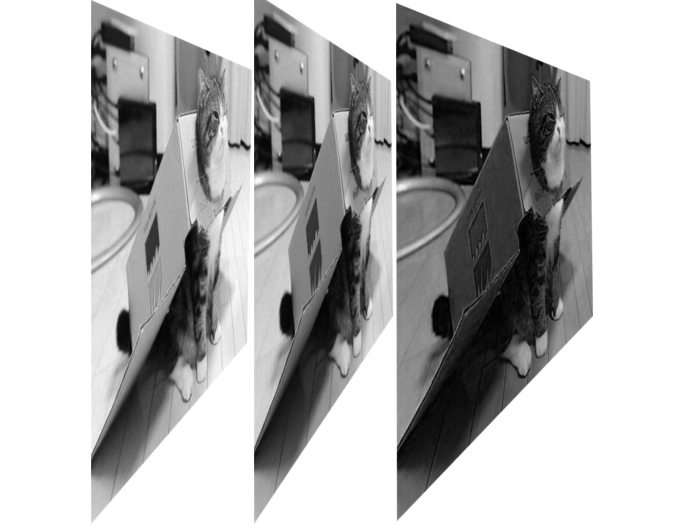

* Как нам работать с такими данными?
* Будет ли эффективна полносвязная сеть?

 ### Давайте напишем и проверим!

* Решим задачу классификации
* В качестве датасета возьмём CIFAR-10
* Напишем сеть на высокоуровневом API keras

In [84]:
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras import layers, models, optimizers, backend, metrics

Для обучения мы будем использовать датасет CIFAR-10, состоящий из 60000 цветных изображений размера 32x32, разбитых на 10 классов, по 6000 изображений на класс. Обучающая выборка состоит из 50000 изображений, а тестовая -- из 10000.

In [33]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Визуализируем классы

In [24]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

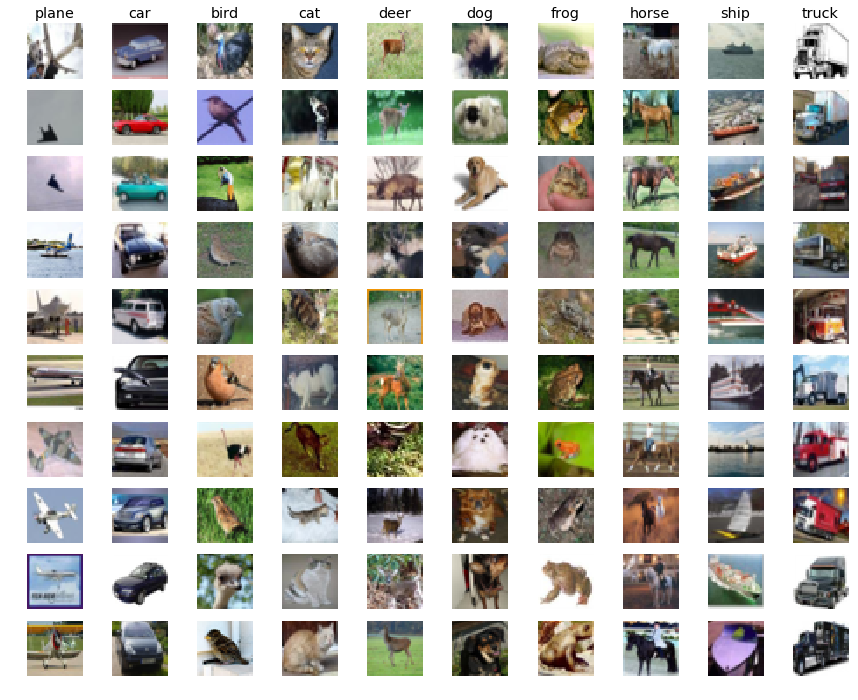

In [25]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Preprocessing: вычитаем среднее

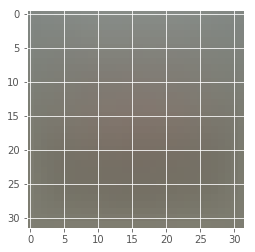

In [27]:
#1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
plt.show()

In [106]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = (x_train - mean_image) / 255
x_test = (x_test - mean_image) / 255

Разделим тренировочную выборку на две части

In [107]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1000)

Попробуем решить задачу при помощи простой нейронной сети. 

### Опишем граф модели

In [141]:
def build_simple_dense_model():
    # Точка входа в граф задаётся при помощи специальных тензоров типа Input
    image_input = layers.Input(shape=(32,32,3))
    
    # В модуле layers находятся готовые примитивы для множетва стандартных слоёв
    x = layers.Flatten()(image_input)
    x = layers.Dense(512, activation='elu')(x)
    x = layers.Dense(256, activation='elu')(x)
    
    # Последний слой возвращает вектор оценок, используем активацию softmax для того, 
    # чтобы привести оценки к вероятностям
    output = layers.Dense(10, activation='softmax')(x)
    
    # Создадим модель. Первый аргумент отвечает за вход(ы), а второй -- за выход(ы)
    model = models.Model(inputs=image_input, outputs=output, name = 'dense_classifier')
    
    #  Для оптимизации будем использовать Adam 
    adam = optimizers.Adam(lr=0.0001)
    
    #Перед испльзованием модель необходимо скомпилировать
    model.compile(adam, 'sparse_categorical_crossentropy', metrics=['acc'])
    
    return model 

Написанная выше функция не осуществляет никаких вычислений, единственное её предназначение -- описание графа.

In [142]:
# Перед созданием модели не забываем очищать сессию
backend.clear_session()
model = build_simple_dense_model()

Keras позволяет выводить на экран удобное табличное описание графа модели

In [143]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 1,707,274
Trainable params: 1,707,274
Non-trainable params: 0
_________________________________________________________________


Так же доступно графическое описание модели

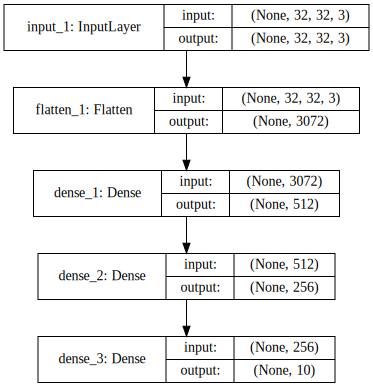

In [144]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Теперь обучим модель. 
Приведённый ниже код будет аналогом тренировочного цикла из примера Tensorflow

In [145]:
model.fit(x=x_train, y=y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val))

Train on 49000 samples, validate on 1000 samples
Epoch 1/10
49000/49000 [==============================] - 4s 72us/step - loss: 1.7459 - acc: 0.3906 - val_loss: 1.6256 - val_acc: 0.4340
Epoch 2/10
49000/49000 [==============================] - 3s 71us/step - loss: 1.5703 - acc: 0.4527 - val_loss: 1.5730 - val_acc: 0.4360
Epoch 3/10
49000/49000 [==============================] - 3s 70us/step - loss: 1.4938 - acc: 0.4809 - val_loss: 1.5231 - val_acc: 0.4530
Epoch 4/10
49000/49000 [==============================] - 3s 67us/step - loss: 1.4366 - acc: 0.5006 - val_loss: 1.4861 - val_acc: 0.4870
Epoch 5/10
49000/49000 [==============================] - 3s 66us/step - loss: 1.3890 - acc: 0.5185 - val_loss: 1.4663 - val_acc: 0.4700
Epoch 6/10
49000/49000 [==============================] - 3s 70us/step - loss: 1.3463 - acc: 0.5331 - val_loss: 1.4087 - val_acc: 0.5090
Epoch 7/10
49000/49000 [==============================] - 3s 65us/step - loss: 1.3062 - acc: 0.5482 - val_loss: 1.4157 - val_acc:

In [148]:
loss, accuracy = model.evaluate(x_test, y_test, batch_size=128)

10000/10000 [==============================] - 1s 53us/step


In [153]:
print(f'accuracy: {accuracy:.2}')

accuracy: 0.52


Совсем не та точность, которую мы ожидали. Как думаете почему?

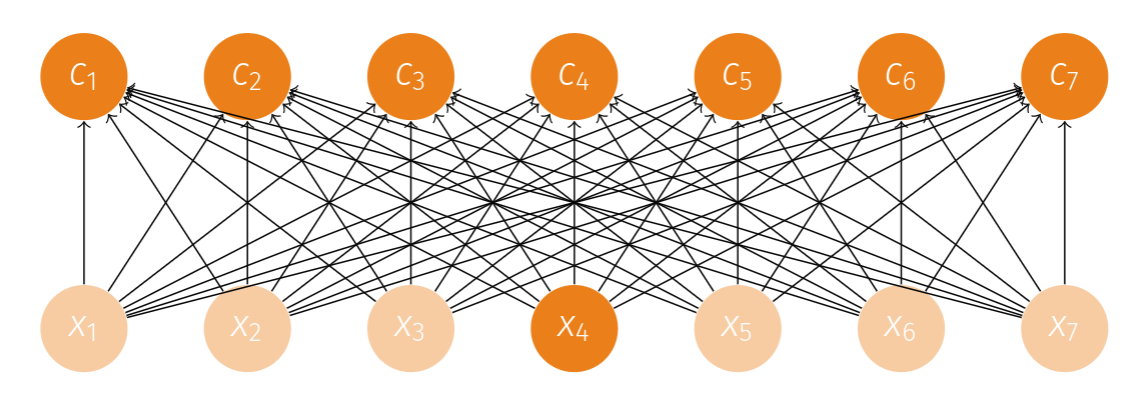

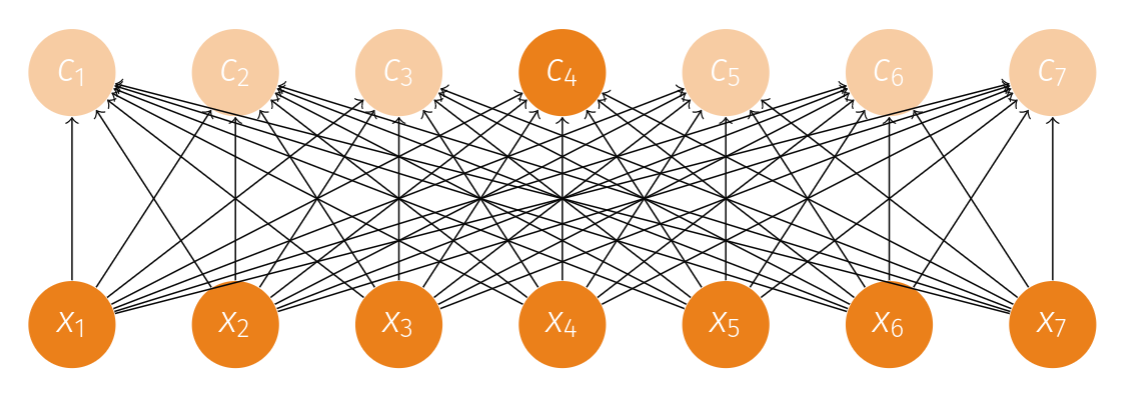

* Каждый вход влияет на каждый узел слоя и наоборот
* Зависит от положения объектов в кадре
* Большое количество параметров. Например для изображения800600 только одно измерение матрицы весов составит480000